Due to recent changes, the Jina model requires gated access, however, it is still free and publicly available. Follow these steps to access the model:

- If you do not have one, sign up at [huggingface.co](https://huggingface.co/).

- Navigate to the Jina model page on Hugging Face.
https://huggingface.co/jinaai/jina-embeddings-v2-base-en

- Click the "Agree and Access Repository" button. This is a mandatory step to access the gated model.

- Generate an Access Token :
1. Go to your account settings by clicking your profile picture > "Settings".
2. Navigate to "Access Tokens" > "New Token".
3. Name your token, select scopes if necessary, and create it.
4. Copy the generated token.


In [1]:
# Replace YOUR_TOKEN_HERE with the token you copied earlier.
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('YOUR_TOKEN_HERE')"

In [2]:
%%capture
!pip install langchain==0.1.5
!pip install langchain_community==0.0.17
!pip install sentence-transformers
!pip install faiss==1.7.2
!pip install faiss-gpu
!pip install evaluate
!pip install rouge_score

In [3]:
!pip install -q -U transformers accelerate bitsandbytes

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import json
from glob import glob
from tqdm.notebook import tqdm

from functools import partial
pd.options.mode.copy_on_write = True

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
ROOT = "/kaggle/input/malawi-public-health-systems-llm-challenge/Malawi Public Health Systems LLM Challenge"

In [6]:
data_train = pd.read_csv(os.path.join(ROOT, "Train.csv"))
data_test = pd.read_csv(os.path.join(ROOT, "Test.csv"))
ss = pd.read_csv(os.path.join(ROOT, "SampleSubmission.csv"))
print(f"Train len: {len(data_train)}")
print(f"Test len: {len(data_test)}")
print(f"Sample Submission len: {len(ss)}")

Train len: 748
Test len: 499
Sample Submission len: 1996


In [7]:
data_train.head()

,ID,Question Text,Question Answer,Reference Document,Paragraph(s) Number,Keywords
0,Q829,Compare the laboratory confirmation methods fo...,Chikungunya is confirmed using serological tes...,TG Booklet 6,"154, 166",Laboratory Confirmation For Chikungunya Vs. Di...
1,Q721,When should specimens be collected for Anthrax...,Specimens should be collected during the vesic...,TG Booklet 6,140,"Anthrax Specimen Collection: Timing, Preparati..."
2,Q464,Which key information should be recorded durin...,"During a register review, key information abou...",TG Booklet 3,439-440,"Register Review, Key Information, Suspected Ca..."
3,Q449,Why is the District log of suspected outbreaks...,The log includes information about response ac...,TG Booklet 3,412,"District Log, Response Activities, Steps Taken..."
4,Q6,What do Community based surveillance strategie...,Community-based surveillance strategies focus ...,TG Booklet 1,86,"Community-based Surveillance Strategies, Ident..."


In [8]:
data_test.head()

,ID,Question Text
0,Q4,"What is the definition of ""unusual event"""
1,Q5,What is Community Based Surveillance (CBS)?
2,Q9,What kind of training should members of VHC re...
3,Q10,What is indicator based surveillance (IBS)?
4,Q13,What is Case based surveillance?


In [9]:
ss.head()

,ID,Target
0,Q1000_keywords,
1,Q1000_paragraph(s)_number,
2,Q1000_question_answer,
3,Q1000_reference_document,
4,Q1002_keywords,


In [10]:
data_train = data_train.dropna().reset_index(drop=True)
# Correct a typo in the train data
data_train.loc[data_train.ID=="Q893", "Paragraph(s) Number"] = "203, 204"

In [11]:
data_train.head()

,ID,Question Text,Question Answer,Reference Document,Paragraph(s) Number,Keywords
0,Q829,Compare the laboratory confirmation methods fo...,Chikungunya is confirmed using serological tes...,TG Booklet 6,"154, 166",Laboratory Confirmation For Chikungunya Vs. Di...
1,Q721,When should specimens be collected for Anthrax...,Specimens should be collected during the vesic...,TG Booklet 6,140,"Anthrax Specimen Collection: Timing, Preparati..."
2,Q464,Which key information should be recorded durin...,"During a register review, key information abou...",TG Booklet 3,439-440,"Register Review, Key Information, Suspected Ca..."
3,Q449,Why is the District log of suspected outbreaks...,The log includes information about response ac...,TG Booklet 3,412,"District Log, Response Activities, Steps Taken..."
4,Q6,What do Community based surveillance strategie...,Community-based surveillance strategies focus ...,TG Booklet 1,86,"Community-based Surveillance Strategies, Ident..."


## Documents Cleaning:

In [13]:
paths = sorted(glob(os.path.join(ROOT, "MWTGBookletsExcel", "*")))
booklets = [pd.read_excel(path, sheet_name="Sheet1", header=None, names=["row_id", "text"]) for path in paths]

In [14]:
#  Useful functions for the extraction of abbreviations.
def get_abbreviation(phrase):
    words = phrase.split()
    stop_words = set(stopwords.words('english'))
    abbreviation = ''.join(word[0].upper() for word in words if word.lower() not in stop_words and word.isalpha())
    return abbreviation

def find_position(main_str, sub_str):
    if sub_str in main_str:
        return main_str.index(sub_str) + len(sub_str)
    else:
        return -1

# Handling misplaced abbreviations :
def get_correct_abb(key, abb):
    words = abb.split()
    stop_words = set(stopwords.words('english'))
    abbreviation = [(word[0].upper(), i) for i, word in enumerate(words) if word.lower() not in stop_words and word.isalpha()]
    abb_word = ''.join(word for word, i in abbreviation)
    index = find_position(abb_word, key)
    if index == -1:
        return abb, abb
    index = abbreviation[index][1]
    return " ".join(words[:index]), " ".join(words[index:])

In [15]:
# Main function for abbreviations extraction :
def extract_abreviations(document, booklet_name, abbreviation_dict={}):

    # Checking if the document has a 'list of abbreviation' Section :
    is_abbreviation = document['text'].str.lower().str.contains('list of abbreviations').fillna(False)
    contain_abb = len(document[is_abbreviation])
    abbreviation_index = 0
    if contain_abb != 0:

        # Getting the abbreviation paragraph :
        abbreviation_index = document.loc[is_abbreviation, "row_id"].values[-1]
        abbreviation_list = document.loc[abbreviation_index, "text"].split('\ufdd0')

        # Parsing abbreviation paragrpah :
        for i in range(0, len(abbreviation_list), 2):
            keys = abbreviation_list[i].split('\u2029')
            abbs = abbreviation_list[i + 1].split('\u2029')

            keys = [x.strip() for x in keys if x.strip()]
            abbs = [x.strip() for x in abbs if x.strip()]

            if len(keys) > len(abbs):
                new_abbs = []
                i = 0
                for abb in abbs:

                    # Using 'get_abbreviation':
                    exracted_abb = get_abbreviation(abb)
                    key = keys[i]
                    if len(exracted_abb) > len(key):

                        # Using 'get_correct_abb':
                        abb_1, abb_2 = get_correct_abb(key, abb)
                        new_abbs.extend([abb_1, abb_2])
                        i += 2
                    else:
                        new_abbs.append(abb)
                        i += 1

                abbs = new_abbs

            # Generating the abbreviation dictionnary :
            for key, abb in zip(keys, abbs):
                if key not in abbreviation_dict.keys():
                    abbreviation_dict[key] = [abb.replace("\xa0", " "), booklet_name, abbreviation_index + 1]

    return abbreviation_dict

In [16]:
def clean_content(text):
    text = re.sub(r"^\d+(\.\d+)*\.?\s*", "", text).strip()
    text = re.sub(r"\.+", "", text)
    return re.sub(r"\s+[ivxlcdm]+\s*$", "", text, flags=re.IGNORECASE)

In [17]:
def extract_table_of_content(booklet):
    booklet["is_in_table"] = booklet.text.apply(lambda x: str(x).lower().strip()).isin(["table of contents", "contents"])
    indice = booklet.loc[booklet.is_in_table, "text"].index[0] + 1
    end_table = clean_content(booklet.loc[indice, "text"].split()[0])
    end_table_indice = booklet.loc[booklet.text.apply(lambda x: str(x).lower().strip() == end_table.lower())].index[0] - 1
    table_of_content = booklet.loc[indice: end_table_indice]
    table_of_content["text"] = table_of_content.text.apply(clean_content)
    return table_of_content.drop(columns=["is_in_table"])

In [18]:
def get_section(text):
    pattern = r"^section (\d+):"
    match = re.search(pattern, text.lower())
    if match:
        section = match.group(1)
    else:
        section = ""
    return section

In [19]:
def add_section_column(df):
    s = df.text.apply(lambda x: x.lower().startswith("section")).cumsum().diff()

    df["section"] = ""
    for i, row in df.loc[df.index.isin(s.loc[s==1].index)].iterrows():
        df.loc[i:, "section"] = get_section(row.text)

    return df

In [20]:
abbreviations = {}
tableOfContent = []
for i in range(len(booklets)):
    booklet_name = re.match(r'^(.+?\d+).*', os.path.basename(paths[i])).group(1)
    booklets[i]["booklet_name"] = booklet_name
    tableOfContent.append(add_section_column(extract_table_of_content(booklets[i])))

for booklet in booklets[::-1]:
    abbreviations = extract_abreviations(booklet, booklet["booklet_name"].unique().item(), abbreviation_dict=abbreviations)

booklets = pd.concat(booklets, axis=0, ignore_index=True)
tableOfContent = pd.concat(tableOfContent, axis=0, ignore_index=True)

In [21]:
booklets.head()

,row_id,text,booklet_name,is_in_table
0,1,Technical Guidelines for﷐INTEGRATED DISEASE SU...,TG Booklet 1,False
1,2,THIRD EDITION,TG Booklet 1,False
2,3,BOOKLET ONE: INTRODUCTION SECTION,TG Booklet 1,False
3,4,￼,TG Booklet 1,False
4,5,DECEMBER 2020,TG Booklet 1,False


In [22]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove special characters
    cleaned_text = re.sub(r'[\ufdd0\u2029]', ' ', text)
    # Remove extra spaces and newlines
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # Remove leading and trailing spaces
    cleaned_text = cleaned_text.strip()
    return cleaned_text

In [23]:
booklets = booklets.dropna()
booklets["text"] = booklets["text"].apply(clean_text)
booklets = booklets.loc[booklets["text"].apply(lambda text:len(text.split())) >= 4].reset_index(drop=True)

In [24]:
booklets

,row_id,text,booklet_name,is_in_table
0,1,technical guidelines for integrated disease su...,TG Booklet 1,False
1,3,booklet one: introduction section,TG Booklet 1,False
2,7,technical guidelines for integrated disease su...,TG Booklet 1,False
3,9,booklet one: introdcution section,TG Booklet 1,False
4,10,this booklet introduces all the eleven modules...,TG Booklet 1,False
...,...,...,...,...
4580,511,"health care associated exposure, including pro...",TG Booklet 6,False
4581,512,working together in close proximity or sharing...,TG Booklet 6,False
4582,513,traveling together with mers‐cov patient in an...,TG Booklet 6,False
4583,514,living in the same household as a mers‐cov pat...,TG Booklet 6,False


In [25]:
def preprocess_query(text):
    text = str(text)
    text = text.lower()
    processed_text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    processed_text = processed_text.strip()
    return processed_text

## Config:

In [26]:
class Config:
    MODELS_DIR = "models"
    DEVICE = "cuda"
    EMBEDDINGS_PATH = "jinaai/jina-embeddings-v2-base-en"

    MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"
    MAX_NEW_TOKENS = 130
    TEMPERATURE = 0.1
    TOP_K = 50
    TOP_P = 0.95
    DO_SAMPLE = True

    CHUNK_SIZE = 500
    CHUNK_OVERLAP = 300
    SEPARATORS = ["\n\n", "\n", ". ", " ", ""]

    VECTORDB_TYPE = "faiss"
    VECTORDB_PATH = "vectordb_faiss"
    VECTORDB_PATH_CONTENT = "vectordb_faiss_content"

CFG = Config()

## Fix seed:

In [27]:
import torch

def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

## Embeddings:

In [28]:
from langchain_community.embeddings import HuggingFaceEmbeddings

In [29]:
def build_base_embeddings(embeddings_path=CFG.EMBEDDINGS_PATH):
    """Builds base embeddings defined in config."""
    base_embeddings = HuggingFaceEmbeddings(
        model_name=embeddings_path,
        model_kwargs={"device": CFG.DEVICE, "trust_remote_code": True},
        encode_kwargs={"batch_size": 4, "show_progress_bar": False}
    )
    return base_embeddings

## LLM:

In [30]:
from transformers import BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quanty_type = "nf4",
    bnb_4bit_use_double_quanty = True
)

torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

model_name = "HuggingFaceH4/zephyr-7b-beta"

tokenizer = AutoTokenizer.from_pretrained(CFG.MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    CFG.MODEL_NAME,
    quantization_config = bnb_config,
    torch_dtype = torch.bfloat16,
    device_map = "auto",
    trust_remote_code = True
)

pipe = pipeline(
    "text-generation",
    model = model,
    tokenizer = tokenizer,
    torch_dtype = torch.bfloat16,
    device_map = "auto"
)

2024-03-06 13:07:48.174816: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 13:07:48.174933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 13:07:48.287300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

In [31]:
def get_response(context, query):
    messages = [
        {   "role": "system",
            "content": "you will work as a questionning assistant giving consistant and short responses giving this context :" + context},
        {"role": "user", "content":'just give me respond to this question brievely (dont exceed 100 words) in one sentence (dont give the abreviation of TG booklet ): and dont write how many words you wrote, just the answer' + query},
    ]
    prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = pipe(prompt, max_new_tokens=130, do_sample=True, temperature=0.1,top_k=50, top_p=0.95)
    response = outputs[0]["generated_text"].split('<|assistant|>')[-1]
    response = response.replace('\n', '')
    return response.lower()

## VectorDB:

In [32]:
from typing import Sequence

from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS

In [33]:
texts = [Document(page_content=row["text"],
                  metadata={"paragraph_number": row["row_id"], "reference_document": row["booklet_name"]})
         for _, row in booklets.iterrows()]

contents = [Document(page_content=row["text"],
                     metadata={"paragraph_number": row["row_id"], "reference_document": row["booklet_name"], "section": row["section"]})
            for _, row in tableOfContent.iterrows()]

In [34]:
def build_vectordb(texts: list, embeddings, do_text_split: bool = True, contents: bool = False, name: str = "") -> None:
    """Builds a vector database from a list of paragraphs.

    Args:
        texts (list): list of paragraphs.
    """
    if do_text_split:
        texts = text_split(texts, CFG.CHUNK_SIZE, CFG.CHUNK_OVERLAP)

    if name:
        path = name
    else:
        path = CFG.VECTORDB_PATH if not contents else CFG.VECTORDB_PATH_CONTENT

    vectorstore = FAISS.from_documents(texts, embeddings, normalize_L2=contents)
    vectorstore.save_local(path)

In [35]:
def text_split(
    doc: Document, chunk_size: int, chunk_overlap: int
) -> Sequence[Document]:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=CFG.SEPARATORS,
        length_function=len,
    )
    return text_splitter.split_documents(doc)

In [36]:
def load_faiss(embeddings, contents=False, name=''):
    if name:
        path = name
    else:
        path = CFG.VECTORDB_PATH if not contents else CFG.VECTORDB_PATH_CONTENT
    return FAISS.load_local(path, embeddings)

## Retrieval QA:

In [37]:
from typing import Any, Dict, List

from langchain.vectorstores.base import VectorStore
from langchain_core.vectorstores import VectorStoreRetriever, BaseRetriever
from langchain_core.pydantic_v1 import Field
from langchain_core.callbacks.manager import CallbackManagerForRetrieverRun

In [38]:
def build_base_retriever_content(vectordb: VectorStore) -> VectorStoreRetriever:
    return vectordb.as_retriever(
        search_kwargs={"k": 1}
    )

In [39]:
def get_the_entire_paragraph(doc):
    conditions = (booklets["booklet_name"]==doc.metadata["reference_document"]) & (booklets["row_id"]==doc.metadata["paragraph_number"])
    return booklets.loc[conditions, "text"].item()

In [40]:
class SaifRetrival(BaseRetriever):
    """Custom Retriever class for VectorStore."""

    vectorstore: Dict[str, VectorStore]
    """VectorStore to use for retrieval."""
    search_kwargs: dict = Field(default_factory=dict)
    """Keyword arguments to pass to the search function."""

    def __int__(self):
        pass

    def _get_relevant_booklet(self, retrieved_docs):
        booklet_scores = {}
        for booklet_name, retrieved_doc in retrieved_docs.items():
            scores = [t[1] for t in retrieved_doc]
            booklet_scores[booklet_name] = np.mean(scores)

        return max(booklet_scores, key=booklet_scores.get)

    def _get_relevant_documents(
            self, query: str, *, run_manager: CallbackManagerForRetrieverRun
    ) -> List[Document]:

        retrieved_docs = {}
        for booklet_name, vectordb in self.vectorstore.items():
            retrieved_docs[booklet_name] = vectordb.similarity_search_with_relevance_scores(query, **self.search_kwargs)

        relevant_booklet = self._get_relevant_booklet(retrieved_docs)
        relevant_document = retrieved_docs[relevant_booklet][0][0]
        entire_paragraph = get_the_entire_paragraph(relevant_document)
        relevant_document.page_content = entire_paragraph

        return [relevant_document]

In [41]:
from typing import Any

from langchain.chains import RetrievalQA
from langchain.llms.base import LLM
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever, EnsembleRetriever
from langchain.vectorstores.base import VectorStore
from langchain_core.vectorstores import VectorStoreRetriever, BaseRetriever
from langchain.retrievers.document_compressors.base import BaseDocumentCompressor

In [42]:
_zephyr_format = """<|system|>
{system}</s>
<|user|>
Question: {user}</s>
<|assistant|>"""

class QA:
    system = "you will work as a questionning assistant giving consistant and short responses giving this context : {context}"

    user = "just give me respond to this question brievely (dont exceed 100 words) in one sentence (dont give the abreviation of TG booklet ): and dont write how many words you wrote, just the answer {question}"

QA_TEMPLATE = _zephyr_format.format(system=QA.system, user=QA.user)

In [43]:
def build_retrieval_qa(llm: LLM, retriever: Any) -> RetrievalQA:
    """Builds a retrieval QA model.

    Args:
        llm (LLM): The language model to use.
        retriever (Any): The retriever to use.

    Returns:
        RetrievalQA: The retrieval QA model.
    """
    retrieval_qa = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=retriever,
        return_source_documents=True,
        chain_type_kwargs={"prompt": PromptTemplate.from_template(QA_TEMPLATE)}, #, "do_sample": CFG.DO_SAMPLE},
    )
    return retrieval_qa

## zero shot prediction:

In [44]:
BASE_EMBEDDINGS = build_base_embeddings()

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/72.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert.py:   0%|          | 0.00/97.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/275M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [45]:
vectordb_dict = {}
for booklet_name in tqdm(booklets["booklet_name"].unique()):
    filtered_texts = [text for text in texts if text.metadata["reference_document"] == booklet_name]
    build_vectordb(filtered_texts, BASE_EMBEDDINGS, name=f"vectordb_faiss_{booklet_name}")
    vectordb = load_faiss(BASE_EMBEDDINGS, name=f"vectordb_faiss_{booklet_name}")
    vectordb_dict[booklet_name] = vectordb

retriever = SaifRetrival(vectorstore=vectordb_dict)

  0%|          | 0/6 [00:00<?, ?it/s]

In [46]:
build_vectordb(contents, BASE_EMBEDDINGS, do_text_split=False, contents=True)
vectordb_contents = load_faiss(BASE_EMBEDDINGS, contents=True)

content_retriever = build_base_retriever_content(vectordb_contents)

In [47]:
data_train.head()

,ID,Question Text,Question Answer,Reference Document,Paragraph(s) Number,Keywords
0,Q829,Compare the laboratory confirmation methods fo...,Chikungunya is confirmed using serological tes...,TG Booklet 6,"154, 166",Laboratory Confirmation For Chikungunya Vs. Di...
1,Q721,When should specimens be collected for Anthrax...,Specimens should be collected during the vesic...,TG Booklet 6,140,"Anthrax Specimen Collection: Timing, Preparati..."
2,Q464,Which key information should be recorded durin...,"During a register review, key information abou...",TG Booklet 3,439-440,"Register Review, Key Information, Suspected Ca..."
3,Q449,Why is the District log of suspected outbreaks...,The log includes information about response ac...,TG Booklet 3,412,"District Log, Response Activities, Steps Taken..."
4,Q6,What do Community based surveillance strategie...,Community-based surveillance strategies focus ...,TG Booklet 1,86,"Community-based Surveillance Strategies, Ident..."


In [48]:
def extract_abbreviation(text):
    matches = [re.sub(r'^\W+|\W+$', '', abb) for abb in text.split() if sum(c.isupper() for c in abb) >= 2]
    if matches:
        return max(matches, key=len)
    else:
        return None

def get_abbreviations(text, abbreviations):
    abb = extract_abbreviation(text)
    if abb:
        for key, value in abbreviations.items():
            if abb.upper() in key.upper().split():
                return value
    return None

In [49]:
def get_similarity_score(ref_emb, query, method="L2"):
    query_emb = BASE_EMBEDDINGS.embed_query(query)

    v1 = np.array(ref_emb, dtype=np.float32)
    v2 = np.array(query_emb, dtype=np.float32)

    if method=="L2":
        v1_norm = np.linalg.norm(v1)
        v2_norm = np.linalg.norm(v2)

        similarity = 1 / (1 + np.linalg.norm(v1_norm-v2_norm))
    elif method=="cosine":
        similarity = np.dot(v1, v2)/ (np.linalg.norm(v1) * np.linalg.norm(v2))

    return similarity

In [50]:
def get_similarity_score_robust(ref_embs, query, method="cosine"):
    scores = []
    for ref_emb in ref_embs:
        score = get_similarity_score(ref_emb, query, method=method)
        scores.append(score)
    return np.mean(scores)

In [51]:
reference_query_abb = "What does the abbreviation 'CDC' stand for?"
reference_query_abb_2 = "What is eDEWS an abbreviation for, and where can I find its meaning in the TG?"
reference_query_abb_3 = "What does HPO stand for, and is it explained in the TG?"

ref_emb_abb = BASE_EMBEDDINGS.embed_query(reference_query_abb)
ref_emb_abb_2 = BASE_EMBEDDINGS.embed_query(reference_query_abb_2)
ref_emb_abb_3 = BASE_EMBEDDINGS.embed_query(reference_query_abb_3)

ref_emb_abbs = [ref_emb_abb, ref_emb_abb_2, ref_emb_abb_3]


reference_query_inc = "Are the case definitions for Neonatal and Non-neonatal tetanus included in the TG?"
reference_query_inc_2 = "Does the TG provide case definitions for Dracunculiasis?"
reference_query_inc_3 = "Is there a Viral haemorrhagic fever case reporting form featured in the TG?"

ref_emb_inc = BASE_EMBEDDINGS.embed_query(reference_query_inc)
ref_emb_inc_2 = BASE_EMBEDDINGS.embed_query(reference_query_inc_2)
ref_emb_inc_3 = BASE_EMBEDDINGS.embed_query(reference_query_inc_3)

ref_emb_incs = [ref_emb_inc, ref_emb_inc_2, ref_emb_inc_3]

In [52]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def remove_stop_words(text):
    text = str(text)
    processed_text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    words = word_tokenize(processed_text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.capitalize() for word in words if word.lower() not in stop_words]
    processed_text = ', '.join(filtered_words)
    return processed_text

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
from time import time

abb_ans = []
queries = data_train.loc[:, "Question Text"].tolist()
responses = {"reference_document": [], "answer": [], "paragraph_number": [], "keywords": []}
response_times = []
for user_query in tqdm(queries, total=len(queries)):
    start = time()
    abb_score = get_similarity_score_robust(ref_emb_abbs, user_query)
    if abb_score > 0.75:
        abb_text = get_abbreviations(user_query, abbreviations)
        if not abb_text:
            abb_text = [' ', ' ', ' ']

        responses["reference_document"].append(abb_text[1])
        responses["answer"].append(abb_text[0])
        responses["paragraph_number"].append(str(abb_text[2]))
        responses["keywords"].append(abb_text[0])
        abb_ans.append(abb_text[0])
    else:
        inc_score = get_similarity_score_robust(ref_emb_incs, user_query)
        if inc_score > 0.775:
            generated_response = content_retriever.get_relevant_documents(user_query)

            page = str(generated_response[0].metadata["paragraph_number"])
            num_booklet = generated_response[0].metadata["reference_document"]
            section = generated_response[0].metadata["section"]
            answer = f"Yes, Page {page} of {num_booklet} Section {section}"

            matches = re.findall(r'\d+', num_booklet)
            if matches:
                num_booklet_extracted =  matches[0]
            else:
                num_booklet_extracted = 6 # default

            keywords = f", Page {page}, Booklet {num_booklet_extracted}, Section {section}"

            responses["reference_document"].append(num_booklet)
            responses["answer"].append(answer)
            responses["paragraph_number"].append(page)
            responses["keywords"].append("TG, " + remove_stop_words(user_query) + keywords)

        else:
            # retieve the relevant booklet
            generated_response = retriever.get_relevant_documents(preprocess_query(user_query))

            responses["reference_document"].append(generated_response[0].metadata["reference_document"])
            responses["answer"].append(" ")
            responses["paragraph_number"].append(str(generated_response[0].metadata["paragraph_number"]))
            responses["keywords"].append(remove_stop_words(user_query))
    end = time()
    response_times.append(start - end)

  0%|          | 0/746 [00:00<?, ?it/s]

In [54]:
from collections import Counter
from sklearn.metrics import accuracy_score

import evaluate

rouge = evaluate.load("rouge")

In [55]:
data_train["is_inclusion_query"] = data_train["Question Answer"].apply(lambda query: query.lower().startswith("yes, page"))
data_train["is_abbreviation_query"] = data_train["Question Text"].apply(lambda query: ("stand for" in query.lower()) \
                                                                                       or ("abbreviation" in query.lower()))

In [56]:
def get_scores_on_booklets():
    # accuracy on all questions
    reference_documents = data_train.loc[:, "Reference Document"].tolist()

    acc = accuracy_score(responses["reference_document"], reference_documents)
    rouge_score = rouge.compute(predictions=responses["reference_document"], references=reference_documents, rouge_types=['rouge1'])["rouge1"]
    print("All questions: ")
    print(f"Accuracy: {acc}")
    print(f"Rouge: {rouge_score}")

    # accuracy on inclusion questions
    indices_is_inc = data_train.loc[(data_train["is_inclusion_query"])].index.tolist()
    filtered_responses = [str(resp) for i, resp in enumerate(responses["reference_document"]) if i in indices_is_inc]
    filtered_references = [ref for i, ref in enumerate(reference_documents) if i in indices_is_inc]

    acc = accuracy_score(filtered_responses, filtered_references)
    rouge_score = rouge.compute(predictions=filtered_responses, references=filtered_references, rouge_types=['rouge1'])["rouge1"]
    print("\nInclusion questions: ")
    print(f"Accuracy: {acc}")
    print(f"Rouge: {rouge_score}")

    # accuracy on abbreviation questions
    indices_is_abb = data_train.loc[(data_train["is_abbreviation_query"])].index.tolist()
    filtered_responses = [str(resp) for i, resp in enumerate(responses["reference_document"]) if i in indices_is_abb]
    filtered_references = [ref for i, ref in enumerate(reference_documents) if i in indices_is_abb]
    acc = accuracy_score(filtered_responses, filtered_references)
    rouge_score = rouge.compute(predictions=filtered_responses, references=filtered_references, rouge_types=['rouge1'])["rouge1"]
    print("\nAbbreviation questions: ")
    print(f"Accuracy: {acc}")
    print(f"Rouge: {rouge_score}")

    # accuracy on the rest of questions
    indices = data_train.loc[(~data_train["is_inclusion_query"]) & (~data_train["is_abbreviation_query"])].index.tolist()
    filtered_responses = [str(resp) for i, resp in enumerate(responses["reference_document"]) if i in indices]
    filtered_references = [ref for i, ref in enumerate(reference_documents) if i in indices]

    acc = accuracy_score(filtered_responses, filtered_references)
    rouge_score = rouge.compute(predictions=filtered_responses, references=filtered_references, rouge_types=['rouge1'])["rouge1"]
    print("\nOther questions: ")
    print(f"Accuracy: {acc}")
    print(f"Rouge: {rouge_score}")

In [57]:
get_scores_on_booklets()

All questions: 
Accuracy: 0.8954423592493298
Rouge: 0.9651474530831099

Inclusion questions: 
Accuracy: 0.967741935483871
Rouge: 0.989247311827957

Abbreviation questions: 
Accuracy: 1.0
Rouge: 1.0

Other questions: 
Accuracy: 0.8849028400597907
Rouge: 0.9621325361235673


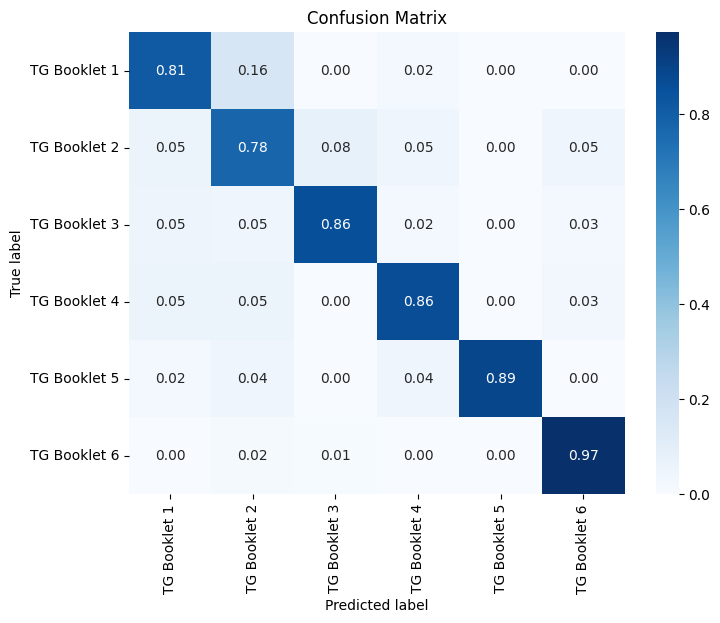

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
# conf_matrix = confusion_matrix(reference_documents, predicted_reference_documents)#, normalize="true")
reference_documents = data_train.loc[:, "Reference Document"].tolist()
conf_matrix = confusion_matrix(reference_documents, responses["reference_document"], normalize="true")

# Define class labels
class_labels = [f'TG Booklet {i}' for i in range(1, 7)]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


In [59]:
def get_scores_on_paragraph():
    # accuracy on all questions
    reference_paragraphs = data_train.loc[:, "Paragraph(s) Number"].tolist()

    acc = accuracy_score(responses["paragraph_number"], reference_paragraphs)
    rouge_score = rouge.compute(predictions=responses["paragraph_number"], references=reference_paragraphs, rouge_types=['rouge1'])["rouge1"]
    print("All questions: ")
    print(f"Accuracy: {acc}")
    print(f"Rouge: {rouge_score}")

    # accuracy on inclusion questions
    indices_is_inc = data_train.loc[(data_train["is_inclusion_query"])].index.tolist()
    filtered_responses = [str(resp) for i, resp in enumerate(responses["paragraph_number"]) if i in indices_is_inc]
    filtered_references = [ref for i, ref in enumerate(reference_paragraphs) if i in indices_is_inc]

    acc = accuracy_score(filtered_responses, filtered_references)
    rouge_score = rouge.compute(predictions=filtered_responses, references=filtered_references, rouge_types=['rouge1'])["rouge1"]
    print("\nInclusion questions: ")
    print(f"Accuracy: {acc}")
    print(f"Rouge: {rouge_score}")

    # accuracy on abbreviation questions
    indices_is_abb = data_train.loc[(data_train["is_abbreviation_query"])].index.tolist()
    filtered_responses = [str(resp) for i, resp in enumerate(responses["paragraph_number"]) if i in indices_is_abb]
    filtered_references = [ref for i, ref in enumerate(reference_paragraphs) if i in indices_is_abb]
    acc = accuracy_score(filtered_responses, filtered_references)
    rouge_score = rouge.compute(predictions=filtered_responses, references=filtered_references, rouge_types=['rouge1'])["rouge1"]
    print("\nAbbreviation questions: ")
    print(f"Accuracy: {acc}")
    print(f"Rouge: {rouge_score}")

    # accuracy on the rest of questions
    indices = data_train.loc[(~data_train["is_inclusion_query"]) & (~data_train["is_abbreviation_query"])].index.tolist()
    filtered_responses = [str(resp) for i, resp in enumerate(responses["paragraph_number"]) if i in indices]
    filtered_references = [ref for i, ref in enumerate(reference_paragraphs) if i in indices]

    acc = accuracy_score(filtered_responses, filtered_references)
    rouge_score = rouge.compute(predictions=filtered_responses, references=filtered_references, rouge_types=['rouge1'])["rouge1"]
    print("\nOther questions: ")
    print(f"Accuracy: {acc}")
    print(f"Rouge: {rouge_score}")

In [60]:
get_scores_on_paragraph()

All questions: 
Accuracy: 0.4785522788203753
Rouge: 0.5458891867739056

Inclusion questions: 
Accuracy: 0.8387096774193549
Rouge: 0.8387096774193549

Abbreviation questions: 
Accuracy: 1.0
Rouge: 1.0

Other questions: 
Accuracy: 0.4260089686098655
Rouge: 0.5011459890383658


In [61]:
for booklet_name in booklets["booklet_name"].unique():
    print(booklet_name)
    filtered_data = data_train.loc[data_train["Reference Document"] == booklet_name, "Paragraph(s) Number"]
    indices = filtered_data.index
    reference_paragraphs_f = filtered_data.tolist()
    predicted__paragraphs_f = [resp for i, resp in enumerate(responses["paragraph_number"]) if i in indices]
    rouge_score = rouge.compute(predictions=predicted__paragraphs_f, references=reference_paragraphs_f, rouge_types=['rouge1'])["rouge1"]
    print(f"Rouge: {rouge_score}")

TG Booklet 1
Rouge: 0.434108527131783
TG Booklet 2
Rouge: 0.44315245478036164
TG Booklet 3
Rouge: 0.39451612903225797
TG Booklet 4
Rouge: 0.30630630630630623
TG Booklet 5
Rouge: 0.3659420289855072
TG Booklet 6
Rouge: 0.7194940476190474


In [62]:
def get_scores_on_keywords():
    # rouge on all questions
    predicted_keywords = responses["keywords"]
    reference_keywords = data_train.loc[:, "Keywords"].tolist()

    rouge_score = rouge.compute(predictions=predicted_keywords, references=reference_keywords, rouge_types=['rouge1'])["rouge1"]
    print("All questions: ")
    print(f"Rouge: {rouge_score}")

    # rouge on inclusion questions
    indices_is_inc = data_train.loc[(data_train["is_inclusion_query"])].index.tolist()
    filtered_responses = [str(resp) for i, resp in enumerate(predicted_keywords) if i in indices_is_inc]
    filtered_references = [ref for i, ref in enumerate(reference_keywords) if i in indices_is_inc]

    rouge_score = rouge.compute(predictions=filtered_responses, references=filtered_references, rouge_types=['rouge1'])["rouge1"]
    print("\nInclusion questions: ")
    print(f"Rouge: {rouge_score}")

    # rouge on abbreviation questions
    indices_is_abb = data_train.loc[(data_train["is_abbreviation_query"])].index.tolist()
    filtered_responses = [str(resp) for i, resp in enumerate(predicted_keywords) if i in indices_is_abb]
    filtered_references = [ref for i, ref in enumerate(reference_keywords) if i in indices_is_abb]
    rouge_score = rouge.compute(predictions=filtered_responses, references=filtered_references, rouge_types=['rouge1'])["rouge1"]
    print("\nAbbreviation questions: ")
    print(f"Rouge: {rouge_score}")

    # rouge on the rest of questions
    indices = data_train.loc[(~data_train["is_inclusion_query"]) & (~data_train["is_abbreviation_query"])].index.tolist()
    filtered_responses = [str(resp) for i, resp in enumerate(predicted_keywords) if i in indices]
    filtered_references = [ref for i, ref in enumerate(reference_keywords) if i in indices]

    rouge_score = rouge.compute(predictions=filtered_responses, references=filtered_references, rouge_types=['rouge1'])["rouge1"]
    print("\nOther questions: ")
    print(f"Rouge: {rouge_score}")

In [63]:
get_scores_on_keywords()

All questions: 
Rouge: 0.47663782327413096

Inclusion questions: 
Rouge: 0.8009019705263897

Abbreviation questions: 
Rouge: 0.8536181210094252

Other questions: 
Rouge: 0.4350445676542


## Inference:

In [64]:
from time import time

queries = data_test.loc[:, "Question Text"].tolist()
responses = {"reference_document": [], "answer": [], "paragraph_number": [], "keywords": []}
response_times = []
for i, user_query in tqdm(enumerate(queries), total=len(queries)):
    start = time()
    abb_score = get_similarity_score_robust(ref_emb_abbs, user_query)
    if abb_score > 0.75:
        abb_text = get_abbreviations(user_query, abbreviations)
        if not abb_text:
            abb_text = [' ', ' ', ' ']

        responses["reference_document"].append(abb_text[1])
        responses["answer"].append(abb_text[0])
        responses["paragraph_number"].append(str(abb_text[2]))
        responses["keywords"].append(abb_text[0])
    else:
        inc_score = get_similarity_score_robust(ref_emb_incs, user_query)
        if inc_score > 0.775:
            generated_response = content_retriever.get_relevant_documents(user_query)

            page = str(generated_response[0].metadata["paragraph_number"])
            num_booklet = generated_response[0].metadata["reference_document"]
            section = generated_response[0].metadata["section"]
            answer = f"Yes, Page {page} of {num_booklet} Section {section}"

            matches = re.findall(r'\d+', num_booklet)
            if matches:
                num_booklet_extracted =  matches[0]
            else:
                num_booklet_extracted = 6 # default

            keywords = f", Page {page}, Booklet {num_booklet_extracted}, Section {section}"

            responses["reference_document"].append(num_booklet)
            responses["answer"].append(answer)
            responses["paragraph_number"].append(page)
            responses["keywords"].append("TG, " + remove_stop_words(user_query) + keywords)

        else:
            # retieve the relevant booklet
            processed_query = preprocess_query(user_query)
            generated_response = retriever.get_relevant_documents(processed_query)

            reference_document = generated_response[0].metadata["reference_document"]
            answer = get_response(generated_response[0].page_content, processed_query)
            # answer = generated_response["result"]
            answer = answer.strip("\n").strip("Answer:").strip()
            paragraph_number = str(generated_response[0].metadata["paragraph_number"])


            responses["reference_document"].append(reference_document)
            responses["answer"].append(answer)
            responses["paragraph_number"].append(paragraph_number)
            responses["keywords"].append(remove_stop_words(user_query))
    end = time()
    response_times.append(start - end)

  0%|          | 0/499 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

KeyboardInterrupt: 

In [ ]:
predicted_answers = [resp for resp in responses["answer"]]
predicted_reference_documents = [resp for resp in responses["reference_document"]]
predicted_reference_paragraphs = [str(resp) for resp in responses["paragraph_number"]]
predicted_keywords = [str(resp) for resp in responses["keywords"]]

In [ ]:
data_test.drop(columns=["is_abbreviation_query"], inplace=True)
data_test["reference_document"] = predicted_reference_documents
data_test["paragraph(s)_number"] = predicted_reference_paragraphs
data_test["keywords"] = predicted_keywords
data_test["question_answer"] = predicted_answers

test = data_test.drop(columns=["Question Text"])

sub = test.melt(id_vars=["ID"], var_name="Value", value_name="Target")

# Combine ID and Target columns
sub["ID"] = sub["ID"] + "_" + sub["Value"]
sub = sub.drop(columns=["Value"])

sub.head()

In [ ]:
submission = ss.drop(columns=["Target"]).merge(sub, on="ID", how="left")
submission.to_csv("submission_with_answers.csv", index=False)
submission